In [1]:
#Imports
import numpy as np
import wandb
import matplotlib.pyplot as plt


In [2]:
# Relevant Sweeps
api = wandb.Api()

BP_Cifar10 = api.sweep("brai-lab/MetaWP/rdlxynh1")
BP_Mnist = api.sweep("brai-lab/MetaWP/yeudfda9")
FFD_Mnist = api.sweep("brai-lab/MetaWP/pqgsrv6j")
FFD_Cifar10 = api.sweep("brai-lab/MetaWP/0jmmy50t")
CFD_Mnist = api.sweep("brai-lab/MetaWP/qzfa1v1l")
CFD_Cifar10 = api.sweep("brai-lab/MetaWP/hc97lew4")

Meta_FFD_CIFAR10 = api.sweep("brai-lab/MetaWP/4sjhorfq")
Meta_CFD_CIFAR10 = api.sweep("brai-lab/MetaWP/z6sw9uuq")

grad_estimation = api.sweep("brai-lab/MetaWP/exxsjl9q")


CFD_CIFAR10_increasing_perts = api.sweep("brai-lab/MetaWP/klkcsplp")
CFD_CIFAR10_increasing_perts2 = api.sweep("brai-lab/MetaWP/p7wzm3eh")
FFD_CIFAR10_increasing_perts = api.sweep("brai-lab/MetaWP/qoemz20p")

In [5]:
def Nr_forward_passes(run, algorithm):
    num_perts = run.config.get("num_perts")
    if "forw" in algorithm.lower() or "ffd" in algorithm.lower():
        Num_passes = int(num_perts + 1)
    elif "cent" in algorithm.lower() or "cfd" in algorithm.lower():
        Num_passes = int(num_perts * 2)
    return Num_passes

In [13]:
def get_metrics(sweep, epochs=499):
    sweep_runs = sweep.runs
    algorithm = []
    Num_passes = np.zeros((len(sweep_runs)))
    loss = np.zeros((len(sweep_runs), epochs))
    acc = np.zeros((len(sweep_runs), epochs))
    angle = np.zeros((len(sweep_runs), epochs))
    ose = np.zeros((len(sweep_runs), epochs))

    for i, run in enumerate(sweep_runs):

        history = run.history(pandas=False)
        algorithm.append(run.config.get("algorithm"))
        Num_passes[i] = (
            Nr_forward_passes(run, algorithm[i])
            if (algorithm[i].lower() != "bp")
            else 1
        )
        # .history apparently does not return things in chronological order https://github.com/wandb/wandb/issues/5219
        for n, epoch in enumerate(history[:epochs]):
            if run.config.get("validation"):
                loss[i,n] = epoch['validation/loss']
                acc[i, n] = epoch["validation/acc"]
            else:
                loss[i,n] = epoch['test/loss']
                acc[i, n] = epoch["test/acc"]

            if(algorithm[i].lower() != "bp"):
                ose[i, n] = epoch["angle/OSE"]
                angle[i, n] = epoch["angle/angle"]

    metric_names = ["loss", "accuracy", "angle", "OSE", "number of passes"]

    return metric_names, [loss, acc, angle, ose, Num_passes, algorithm]

In [20]:
#_, grad_estimation_stats = get_metrics(grad_estimation,99)


_, CFD_CIFAR10_increasing_perts_stats = get_metrics(CFD_CIFAR10_increasing_perts,99)
_, CFD_CIFAR10_increasing_perts2_stats = get_metrics(CFD_CIFAR10_increasing_perts2,99)
_, FFD_CIFAR10_increasing_perts_stats = get_metrics(FFD_CIFAR10_increasing_perts,99)



In [21]:
for stat in range(len(CFD_CIFAR10_increasing_perts_stats)):
    print(CFD_CIFAR10_increasing_perts_stats[stat].shape)
    print(CFD_CIFAR10_increasing_perts2_stats[stat].shape)

    CFD_CIFAR10_increasing_perts_stats[stat] = np.append(
        CFD_CIFAR10_increasing_perts_stats[stat],
        CFD_CIFAR10_increasing_perts2_stats[stat], 
        axis=0
    )


(32, 99)
(128, 99)
(32, 99)
(128, 99)
(32, 99)
(128, 99)
(32, 99)
(128, 99)
(32,)
(128,)


AttributeError: 'list' object has no attribute 'shape'

In [ ]:
_, Meta_FFD_CIFAR10_stats = get_metrics(Meta_FFD_CIFAR10)
_, Meta_CFD_CIFAR10_stats = get_metrics(Meta_CFD_CIFAR10)
_, grad_estimation_stats = get_metrics(grad_estimation)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

In [8]:
metric_names, FFD_CIFAR10_stats = get_metrics(FFD_Cifar10)
_, CFD_CIFAR10_stats = get_metrics(CFD_Cifar10)
_, BP_CIFAR10_stats = get_metrics(BP_Cifar10)

_, FFD_MNIST_stats = get_metrics(FFD_Mnist)
_, CFD_MNIST_stats = get_metrics(CFD_Mnist)
_, BP_MNIST_stats = get_metrics(BP_Mnist)



False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

In [5]:
def make_boxplots(FFD_stats, CFD_stats, BP_stats, name):

    cfd_acc = np.split(np.flip(CFD_stats[1][:, -1]), 3)
    cfd_loss = np.split(np.flip(CFD_stats[0][:, -1]), 3)
    ffd_acc = np.split(np.flip(FFD_stats[1][:, -1]), 3)
    ffd_loss = np.split(np.flip(FFD_stats[0][:, -1]), 3)
    accs = [BP_stats[1][:, -1]]
    losses = [BP_stats[0][:, -1]]
    labels = ["(BP) " + str(1)]

    CFD_num_passes = np.unique(CFD_stats[4])
    FFD_num_passes = np.unique(FFD_stats[4])

    for i in range(3):
        labels.append("(FFD) " + str(int(FFD_num_passes[i])))

        labels.append("(CFD) " + str(int(CFD_num_passes[i])))
        accs.append(ffd_acc[i])
        accs.append(cfd_acc[i])
        losses.append(ffd_loss[i])
        losses.append(cfd_loss[i])

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
    f.set_dpi(400)
    ax1.set_title(f"Accuracy vs number of forward passes on {name}")
    ax1.set_ylabel("Accuracy (test set)")

    ax1.set_xlabel("Nr. forward passes")
    ax1.boxplot(accs, tick_labels=labels)

    ax2.set_title(f"Loss vs number of forward passes on {name}")
    ax2.set_ylabel("Loss (test set)")

    ax2.set_xlabel("Nr. forward passes")
    ax2.boxplot(losses, tick_labels=labels)

    plt.show()    

In [6]:
def plot_trajectory(
    Sweeps,
    metric_indexes,
    metric_names,
    task_name,
    group_selection: tuple = (3, [0, 1, 2]),
):
    """
    Sweeps : list
        List of arrays containing the results (accuracy, loss, angle etc.) of a Sweep

    metric_indexes : list
        List containing indexes, representing which tasks should be plotted

    metric_names : list
        List containing names of metrics

    task_name : str
        Which task was tried, like CIFAR10 or MNIST

    Group selection : tuple
        Tuple containing how many groups there are for plotting, and how many of those groups should be plotted

    """
    f, axs = plt.subplots(1, len(metric_indexes), figsize=(5 * len(metric_indexes), 5))
    f.set_dpi(400)
    x = np.linspace(1, 499, num=499)

    # Will need to

    for count, metric_index in enumerate(metric_indexes):
        for Sweep in Sweeps:
            algorithms = np.unique(Sweep[5])

            labels = np.array(
                [
                    "(" + algorithm + "): " + str(num_passes)
                    for num_passes in np.flip(np.unique(Sweep[4]))
                    for algorithm in algorithms
                ]
            )

            labels = labels[group_selection[1]]

            metric = (
                Sweep[metric_index]
                if algorithms[0].lower() == "bp"
                else np.array(np.split(Sweep[metric_index], group_selection[0], axis=0))
            )[group_selection[1]]

            metric = np.transpose(metric)
            mean = np.mean(
                metric, axis=1
            )  # metric is number of groups by number of runs by epochs
            q1 = np.percentile(metric, 25, axis=1)
            q3 = np.percentile(metric, 75, axis=1)
            axs[count].plot(x, mean, label=labels)

            for q in range(q1.shape[-1]):
                axs[count].fill_between(x, q1[:, q], q3[:, q], alpha=0.5, label="")

        axs[count].set_title(
            f"{metric_names[metric_index]} over training on test set for {task_name}"
        )
        axs[count].legend()
    plt.show()

In [ ]:
def plot_scatter(
    Sweeps,
    metric_indexes,
    metric_names,
    task_name,
    group_selection: tuple = (3, [0, 1, 2]),
):
    """
    Sweeps : list
        List of arrays containing the results (accuracy, loss, angle etc.) of a Sweep

    metric_indexes : list
        List containing indexes, representing which tasks should be plotted

    metric_names : list
        List containing names of metrics

    task_name : str
        Which task was tried, like CIFAR10 or MNIST

    Group selection : tuple
        Tuple containing how many groups there are for plotting, and how many of those groups should be plotted

    """
    f, axs = plt.subplots(1, len(metric_indexes), figsize=(5 * len(metric_indexes), 5))
    f.set_dpi(400)
    for count, metric_index in enumerate(metric_indexes):
        for Sweep in Sweeps:
            algorithms = np.unique(Sweep[5])
            num_runs = Sweep[4]

            labels = np.array(
                [
                    "(" + algorithm + "): " + str(num_passes)
                    for num_passes in np.flip(np.unique(Sweep[4]))
                    for algorithm in algorithms
                ]
            )
            print(labels)
            labels = labels[group_selection[1]]
            print(len(Sweep[metric_index]))
            print(group_selection[0])
            metric = (
                Sweep[metric_index]
                if algorithms[0].lower() == "bp"
                else np.array(np.split(Sweep[metric_index], group_selection[0], axis=0))
            )[group_selection[1]]

            metric = np.transpose(metric)
            mean = np.mean(
                metric, axis=1
            )  # metric is number of groups by number of runs by epochs

            axs[count].scatter(num_runs, mean, label=labels)

        axs[count].set_title(
            f"{metric_names[metric_index]} over training on test set for {task_name}"
        )
        axs[count].legend()
    plt.show()

['(CFD): 64.0' '(CFD): 62.0' '(CFD): 60.0' '(CFD): 58.0' '(CFD): 56.0'
 '(CFD): 54.0' '(CFD): 52.0' '(CFD): 50.0' '(CFD): 48.0' '(CFD): 46.0'
 '(CFD): 44.0' '(CFD): 42.0' '(CFD): 40.0' '(CFD): 38.0' '(CFD): 36.0'
 '(CFD): 34.0' '(CFD): 32.0' '(CFD): 30.0' '(CFD): 28.0' '(CFD): 26.0'
 '(CFD): 24.0' '(CFD): 22.0' '(CFD): 20.0' '(CFD): 18.0' '(CFD): 16.0'
 '(CFD): 14.0' '(CFD): 12.0' '(CFD): 10.0' '(CFD): 8.0' '(CFD): 6.0'
 '(CFD): 4.0' '(CFD): 2.0']
32


ValueError: array split does not result in an equal division

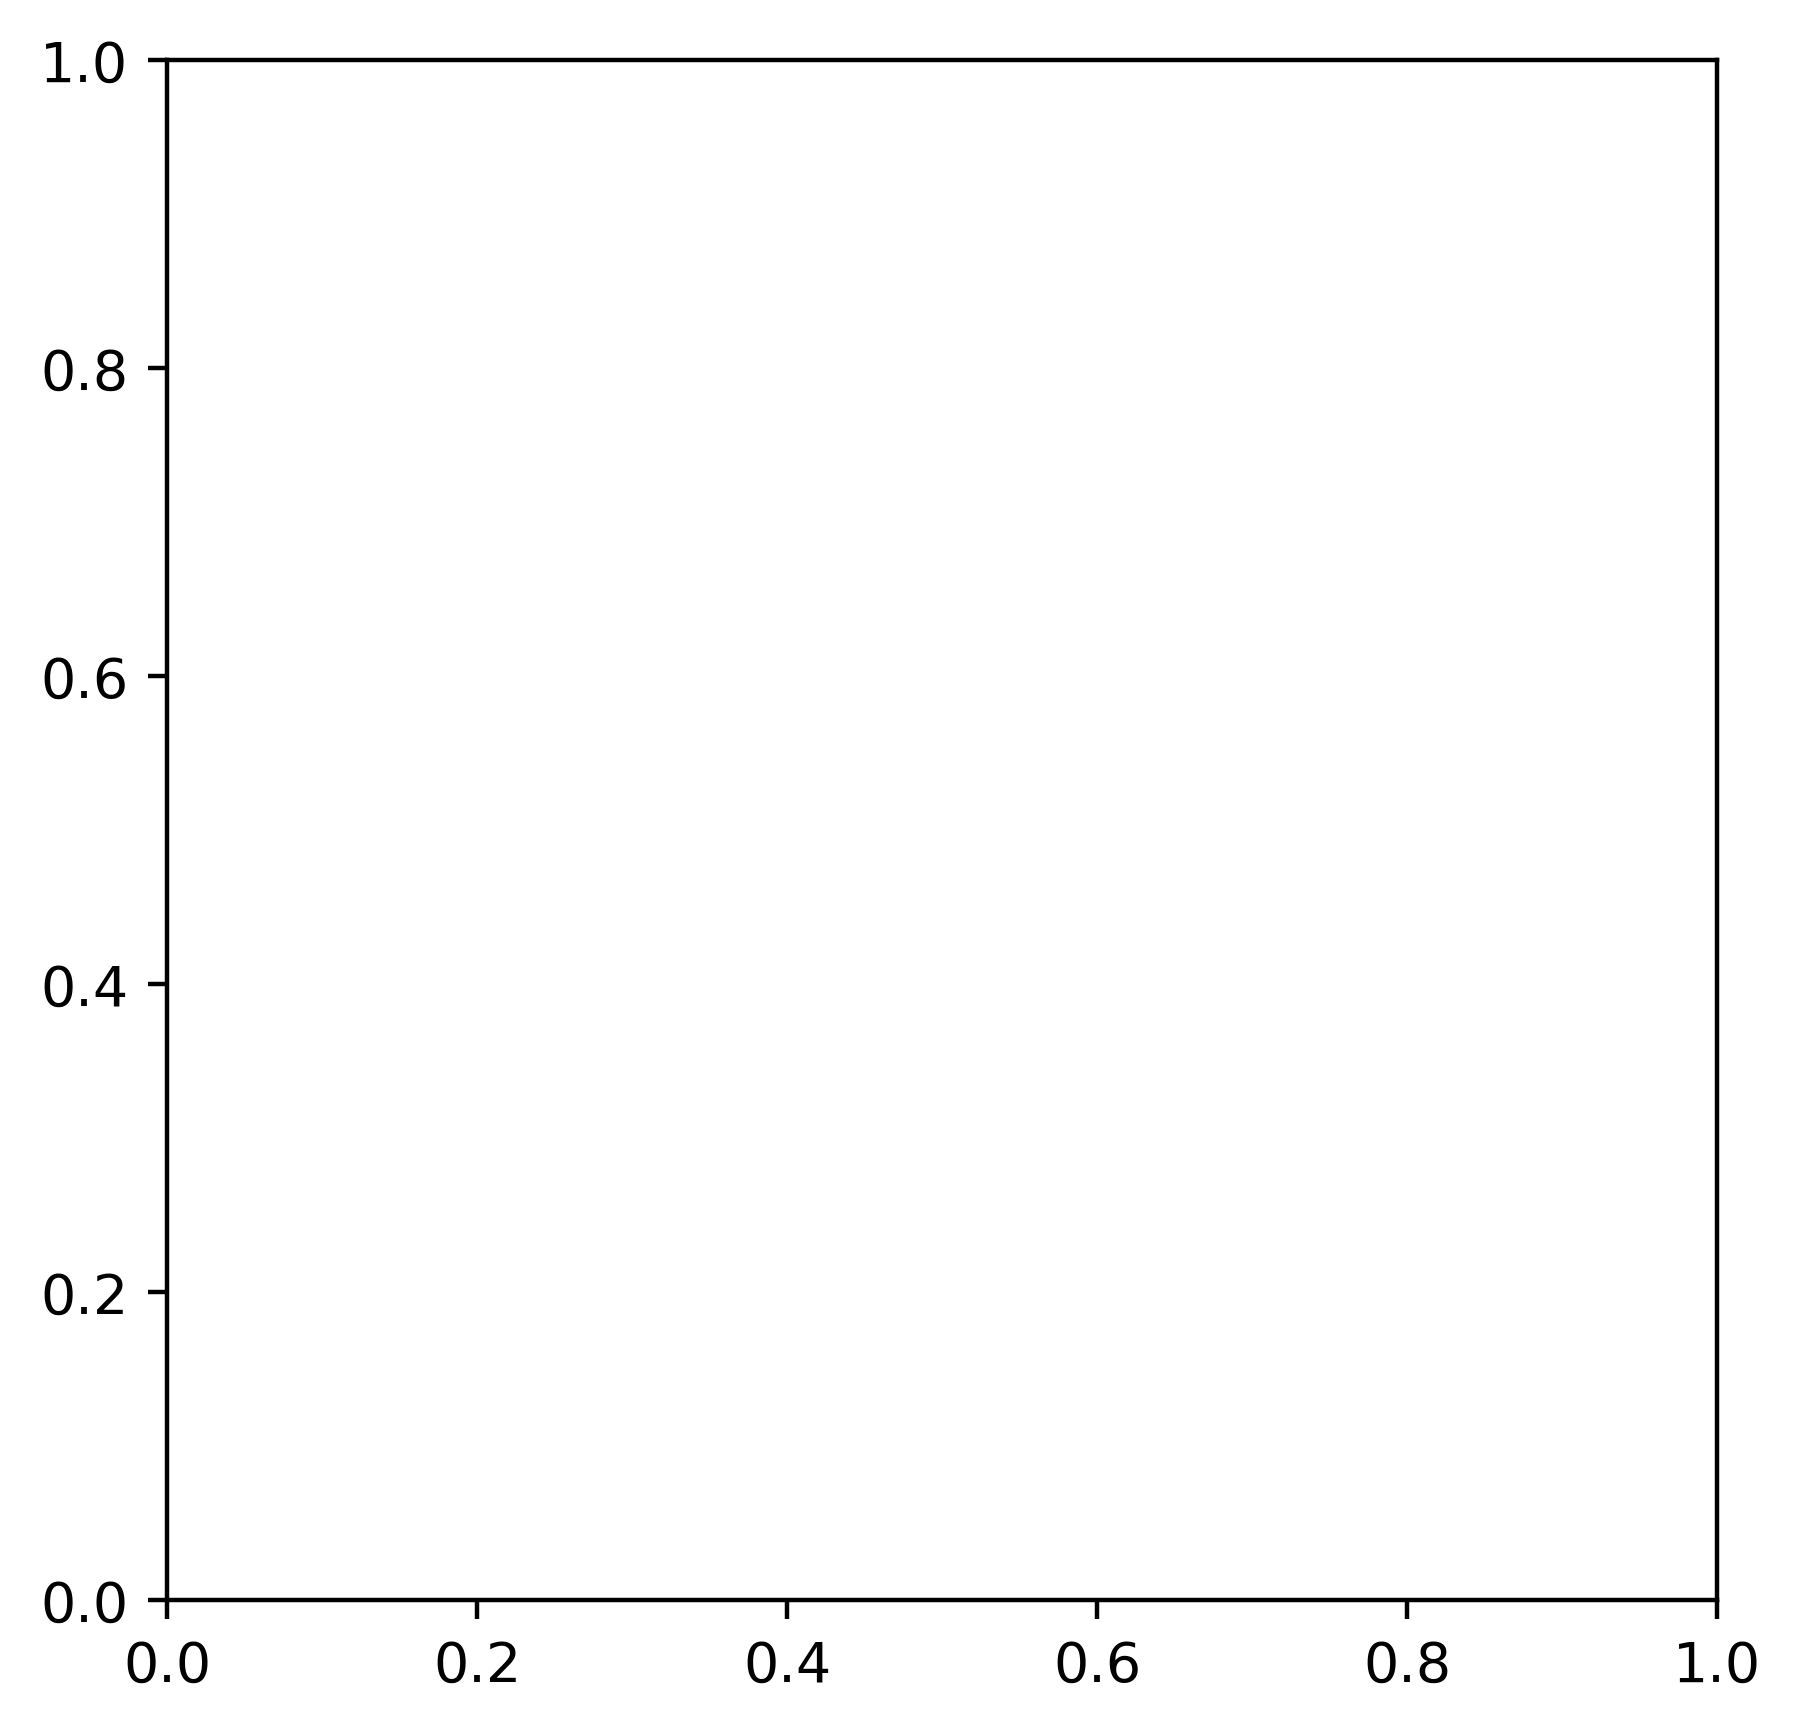

In [28]:
sweeps = [CFD_CIFAR10_increasing_perts_stats,
CFD_CIFAR10_increasing_perts2_stats,
FFD_CIFAR10_increasing_perts_stats]

indexes = [0]
group_selection = (32, np.linspace(1,32,32))

plot_scatter(sweeps, indexes, "CIFAR10", group_selection)

['FFD']


AttributeError: 'numpy.ndarray' object has no attribute 'lower'

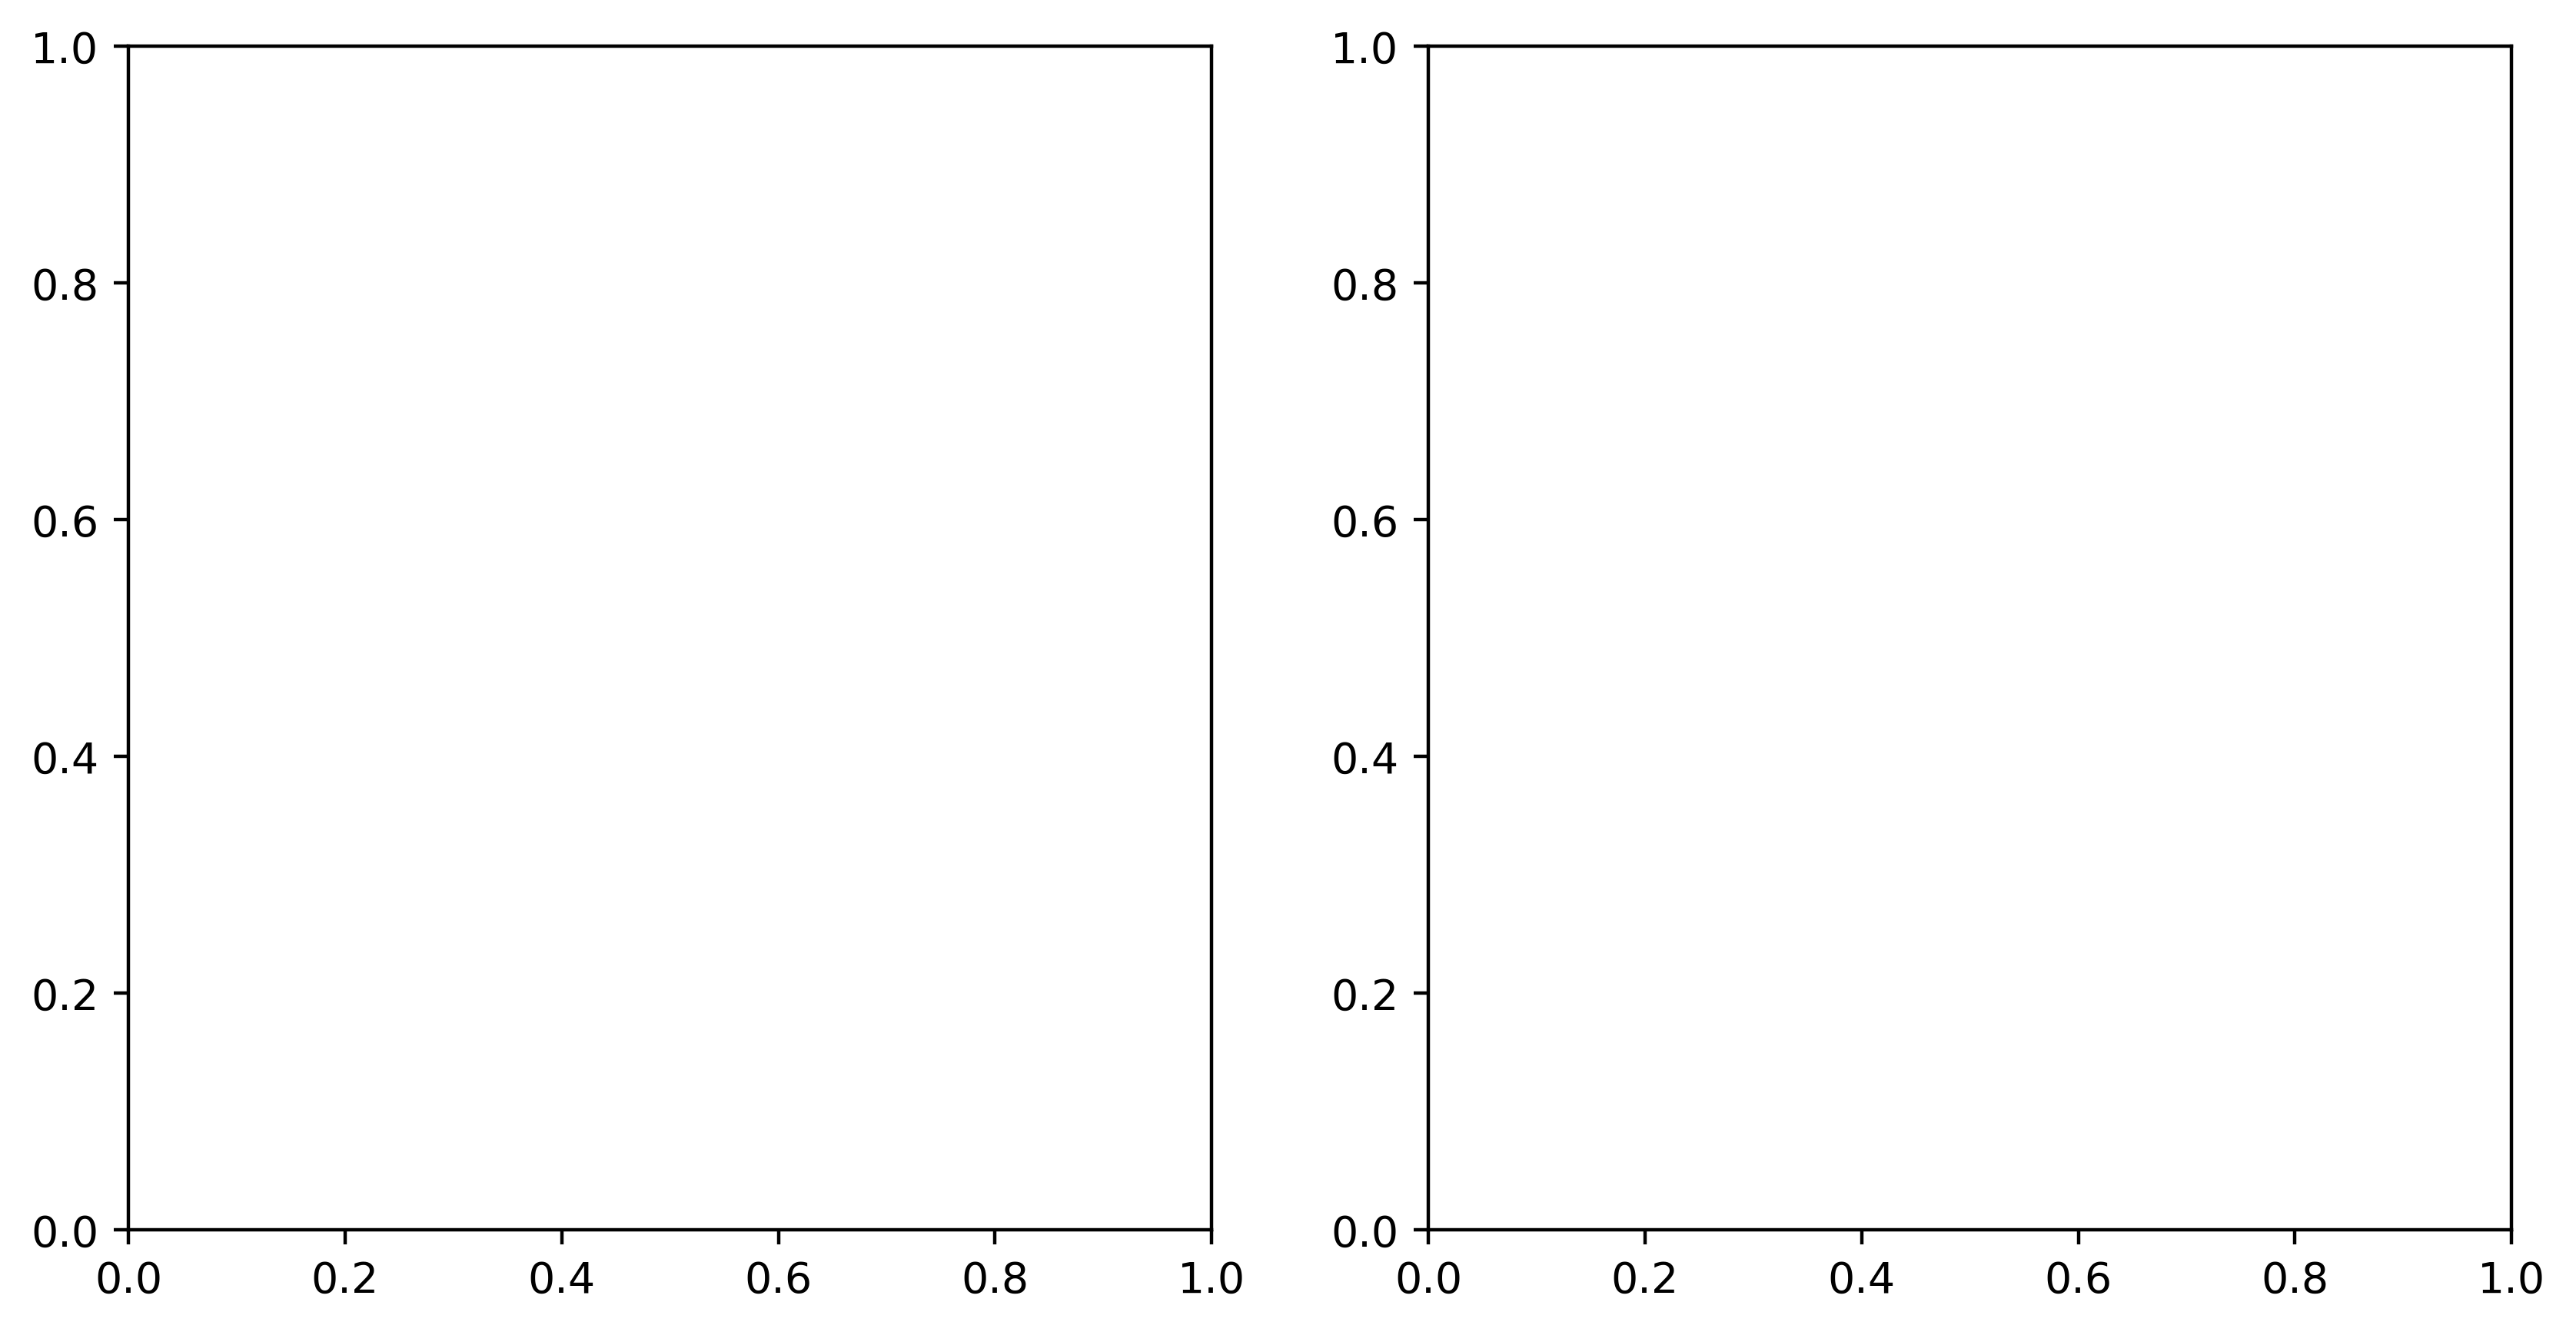

In [ ]:
Sweeps = [
    Meta_FFD_CIFAR10_stats,
    FFD_CIFAR10_stats,
]
indexes = [0, 1]
group_selection = (3, [2])
plot_trajectory(Sweeps, indexes, metric_names, "CIFAR10", group_selection)

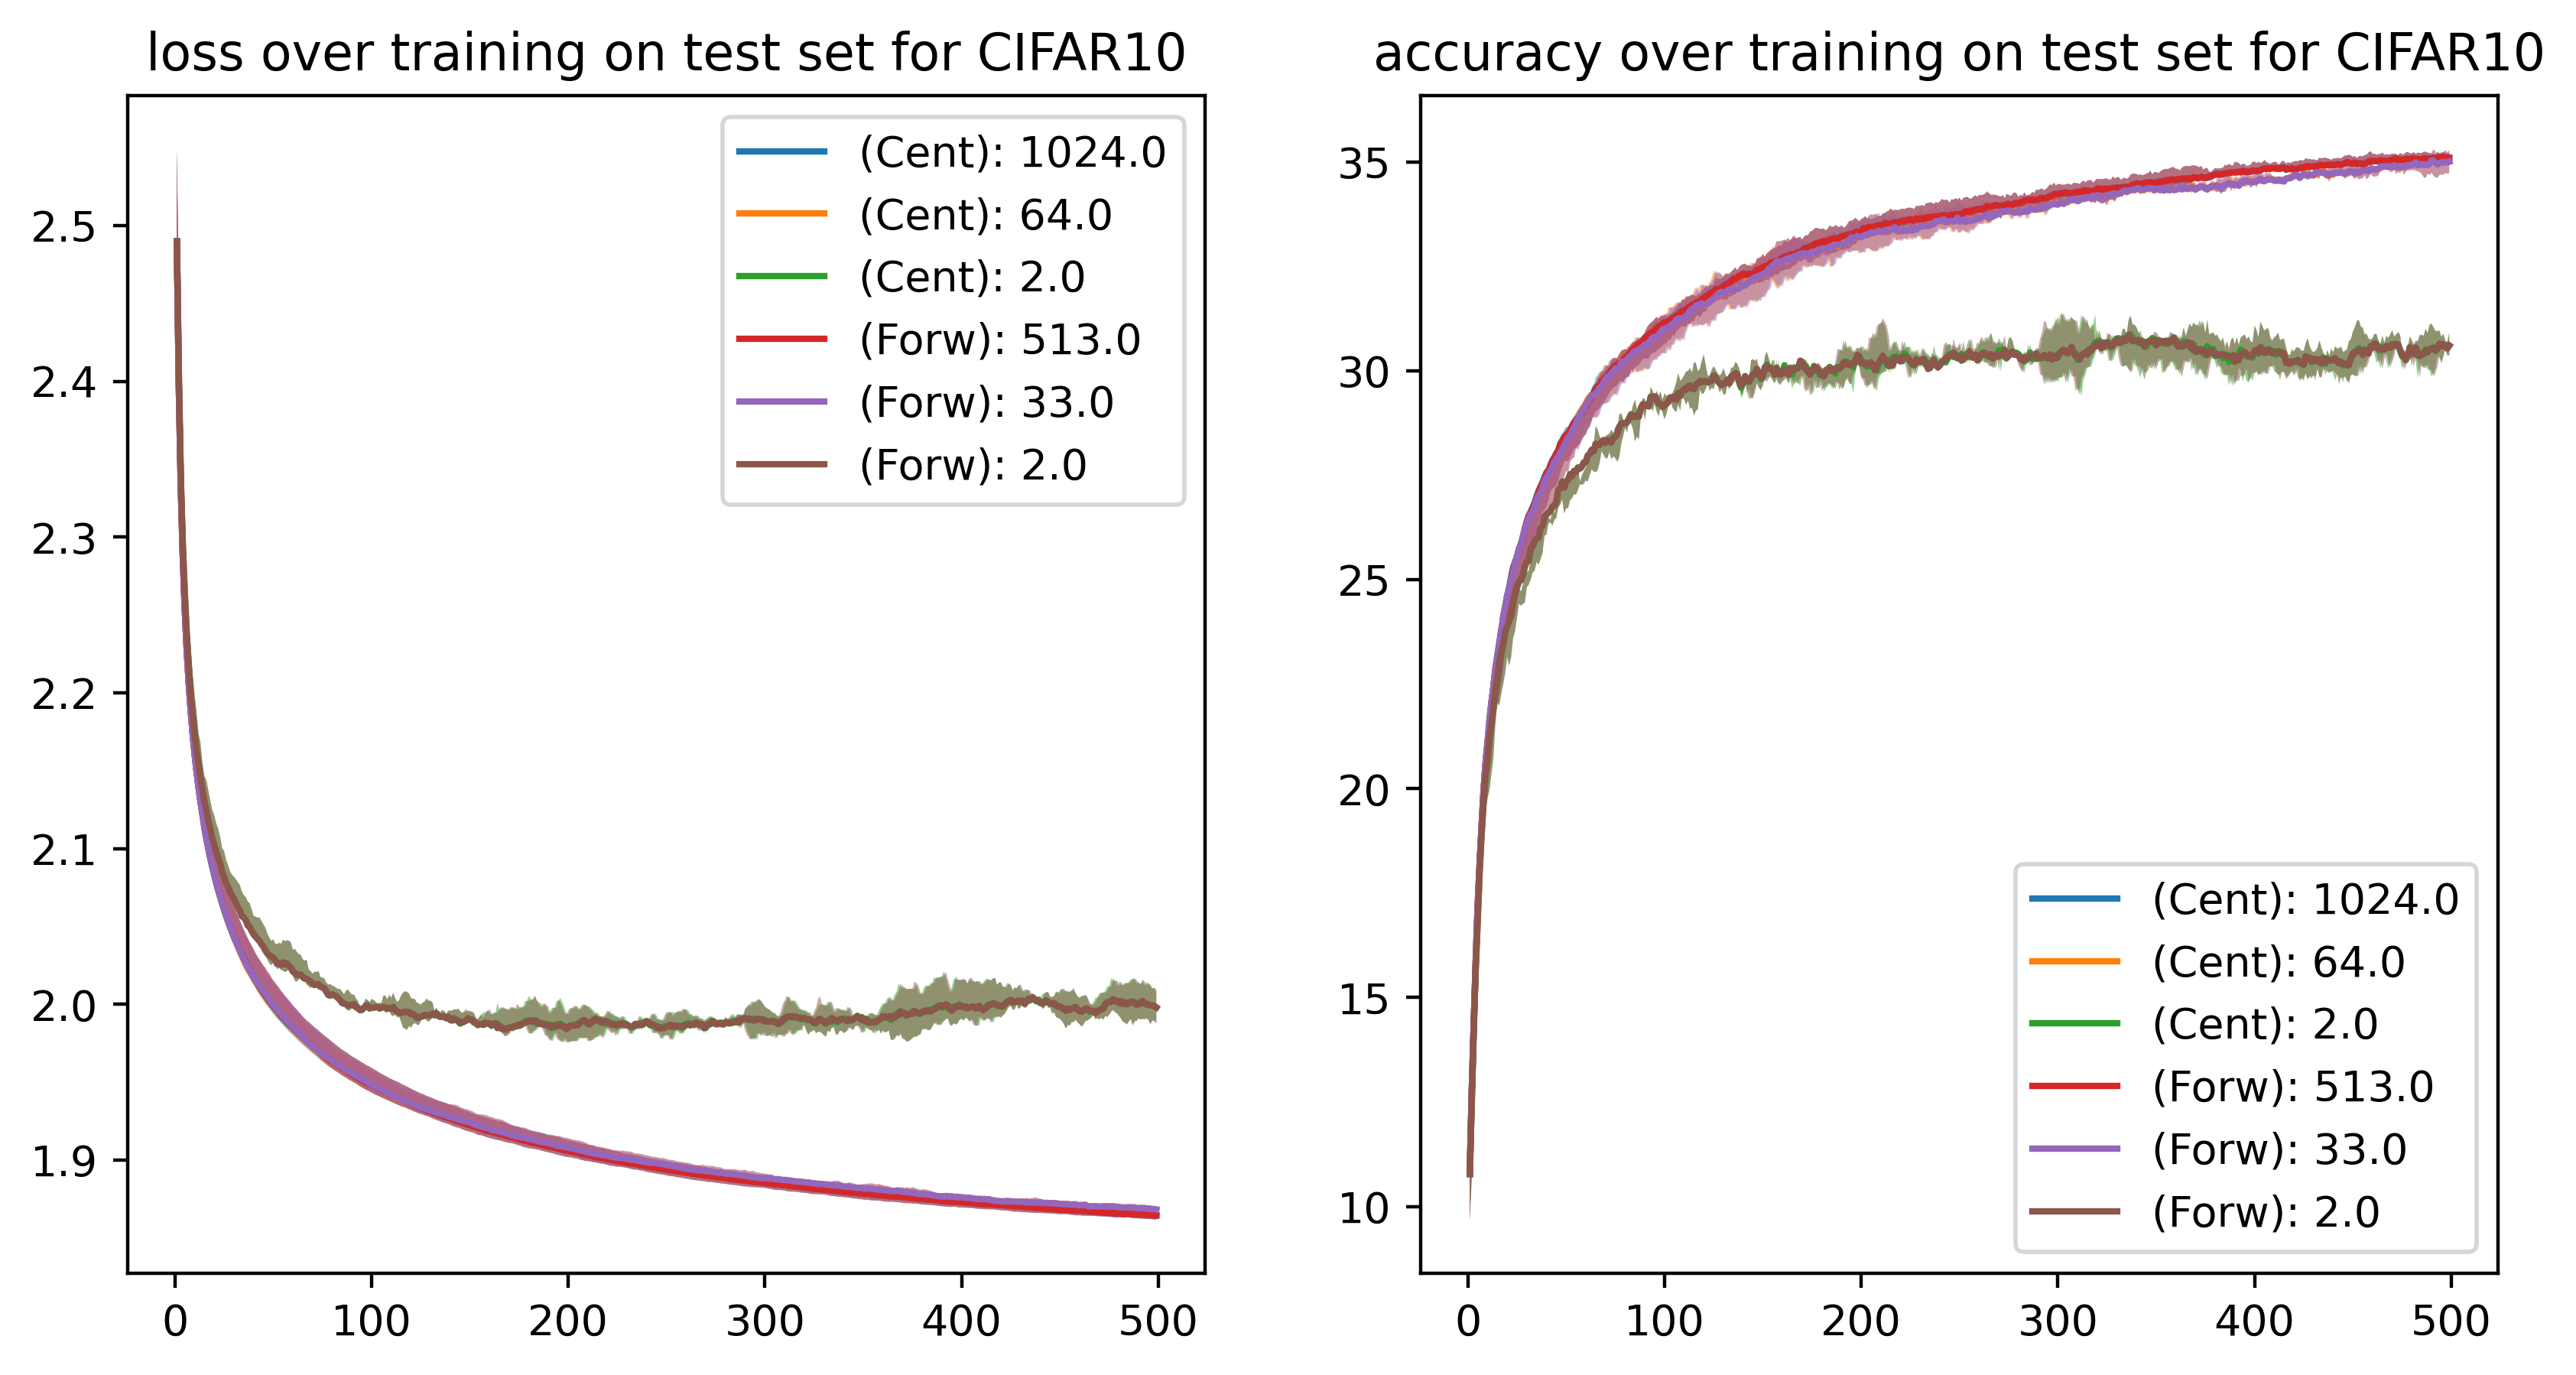

In [ ]:
Sweeps = [CFD_CIFAR10_stats, FFD_CIFAR10_stats, ]
indexes = [0,1]
plot_trajectory(Sweeps, indexes, metric_names, "CIFAR10")

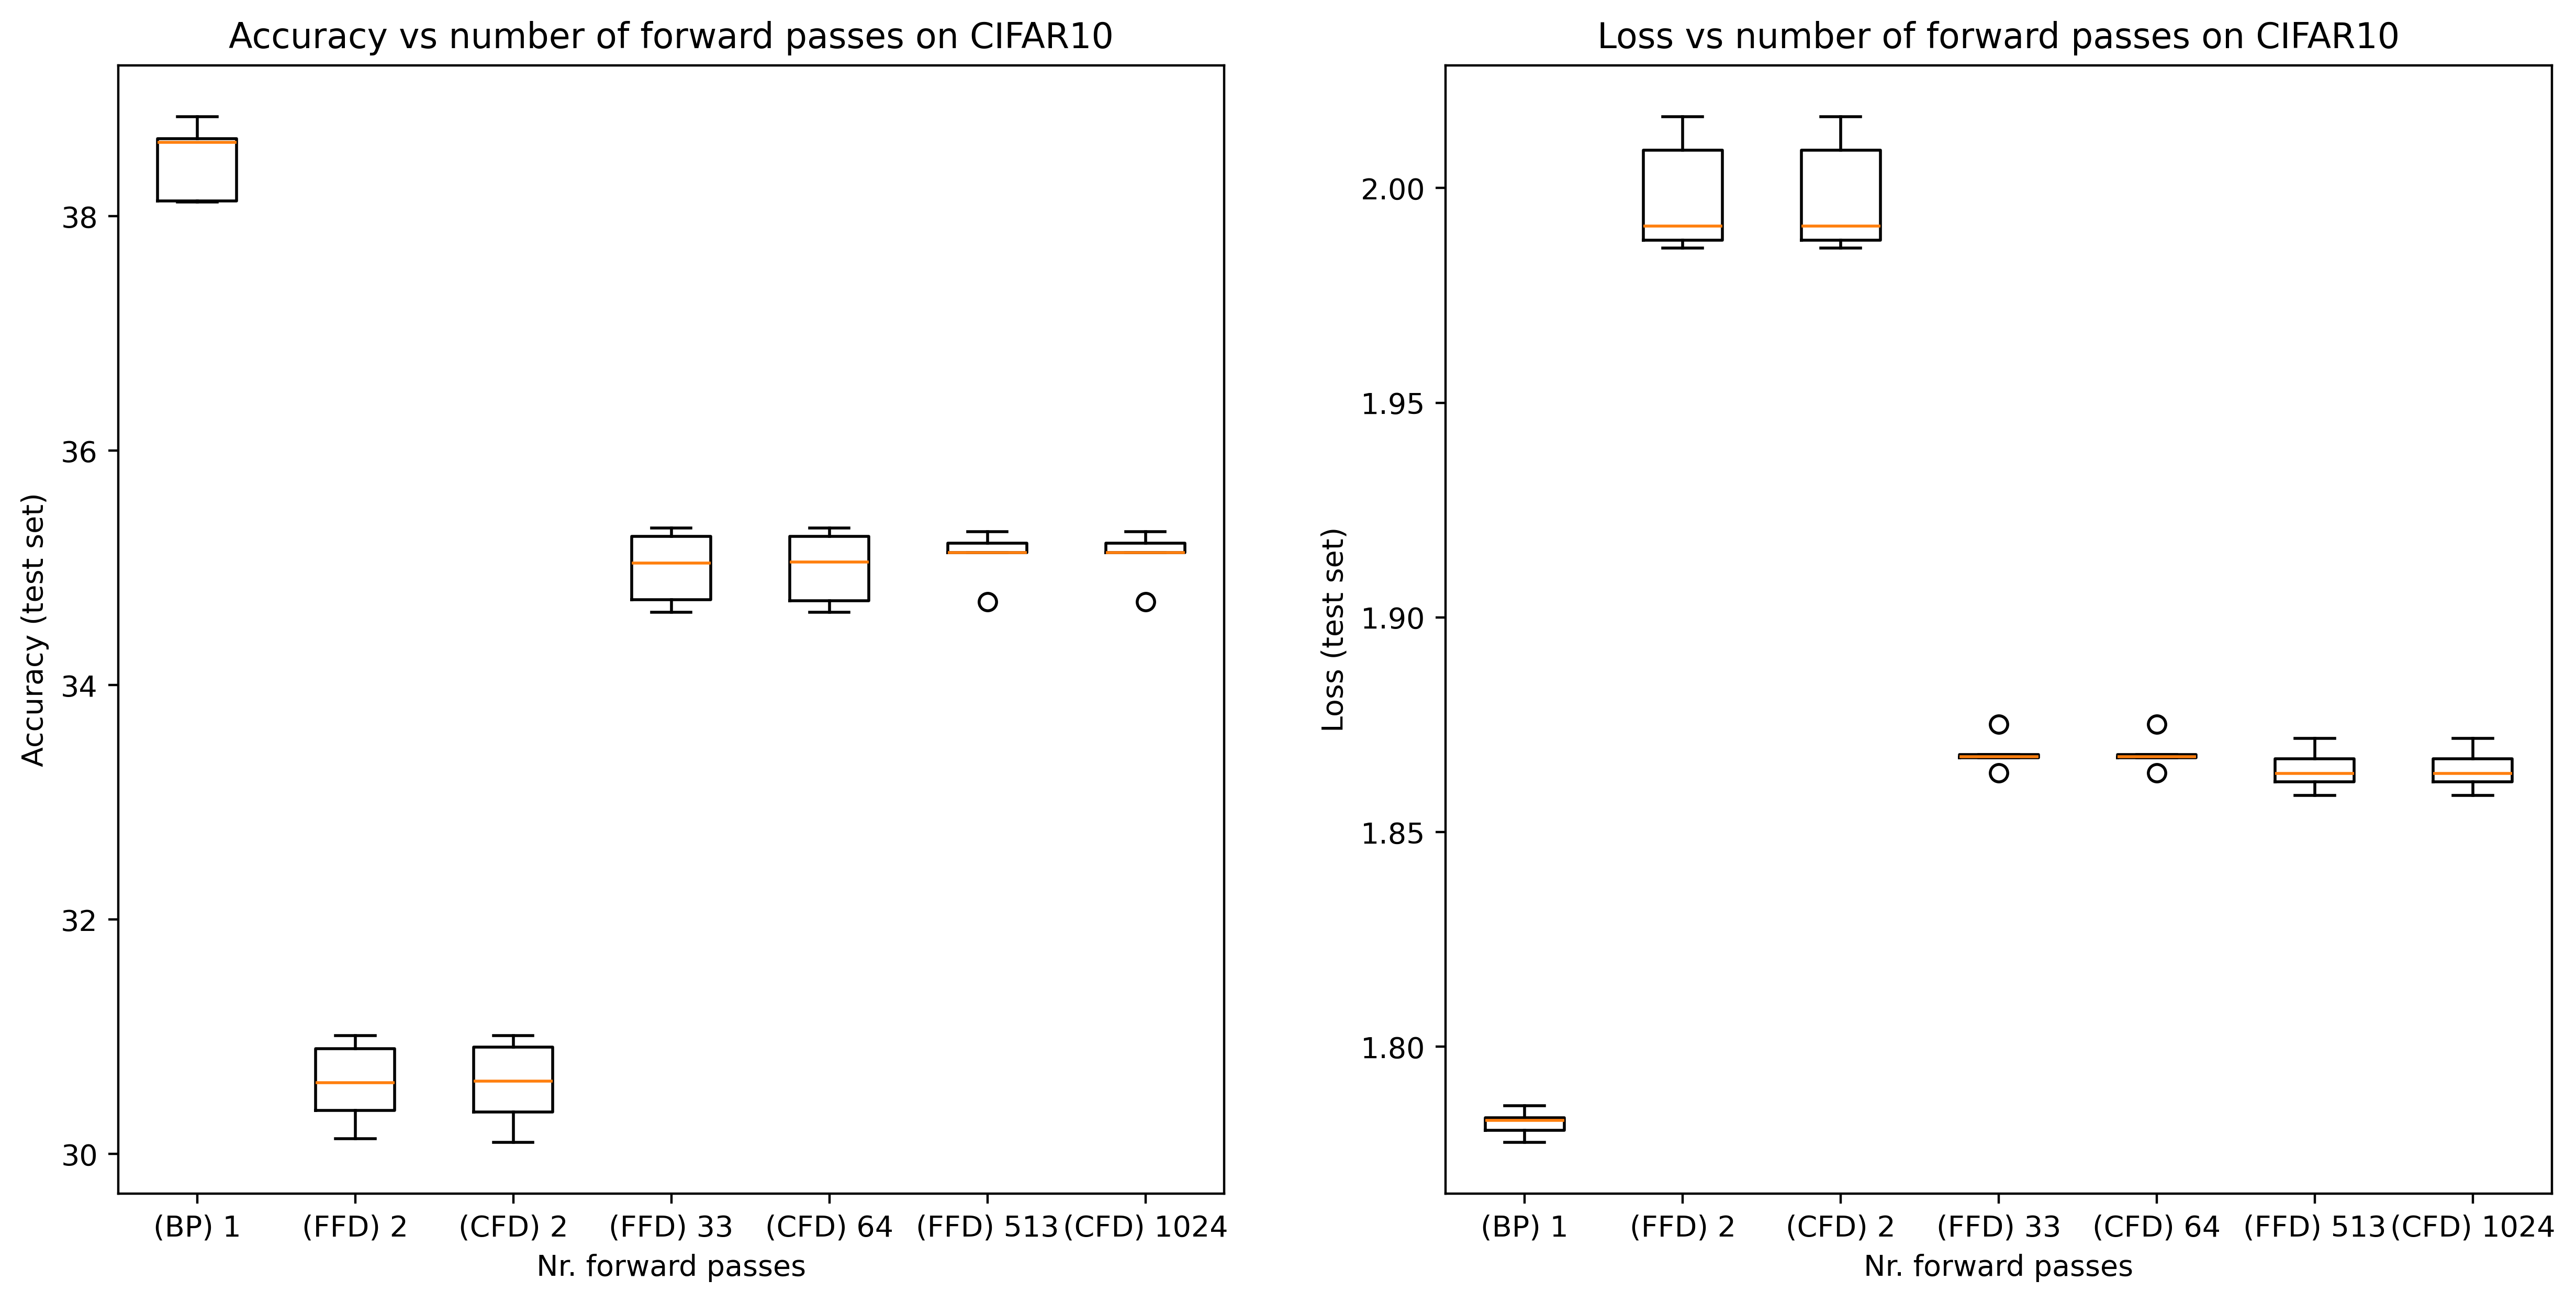

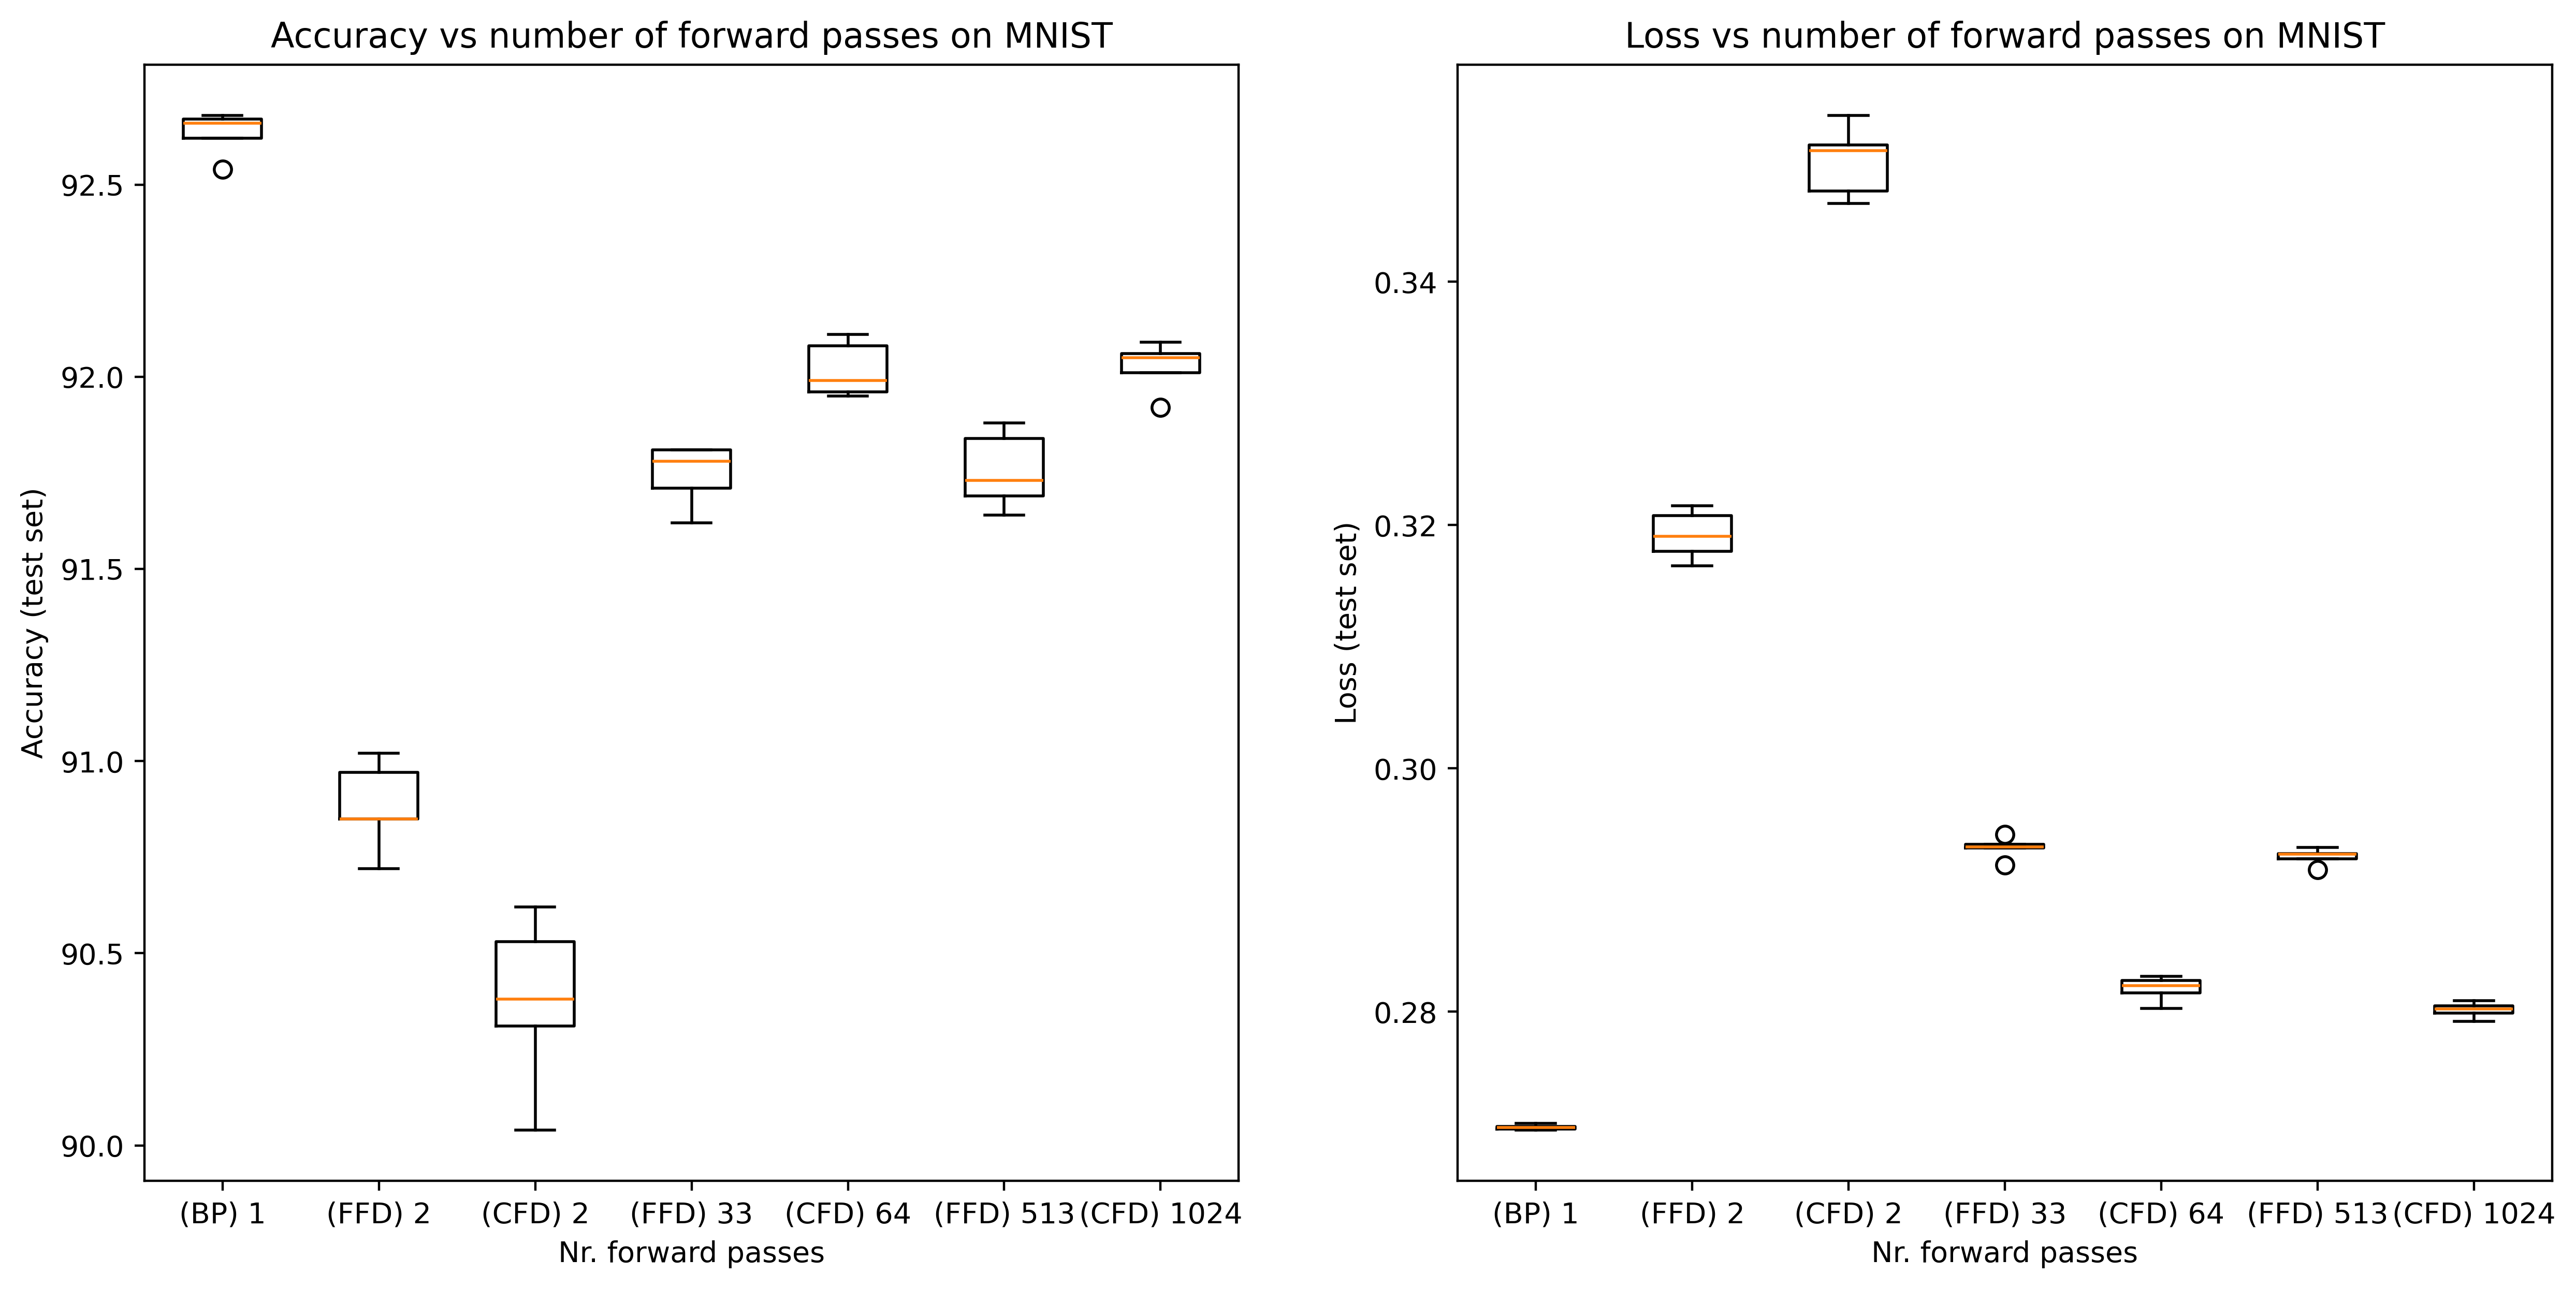

In [ ]:
make_boxplots(FFD_CIFAR10_stats, CFD_CIFAR10_stats, BP_CIFAR10_stats, "CIFAR10")
make_boxplots(FFD_MNIST_stats, CFD_MNIST_stats, BP_MNIST_stats, "MNIST")

# very surprising that they should be so similar, but it is the case:
# https://wandb.ai/brai-lab/MetaWP/runs/18y6z1jh/logs - ffd
# https://wandb.ai/brai-lab/MetaWP/runs/eh2isu8h/logs - cfd - in the last epoch, the loss is only smaller by 1e-7